In [240]:
import numpy as np
import matplotlib.pyplot as plt
import random 

def sigmoid_decay(initial_value, final_value, steps, steepness, midpoint):
    """ Calculate a sigmoid-like decay for the step size. """
    return final_value + (initial_value - final_value) / (1 + np.exp(steepness * (np.arange(steps) - midpoint)))


def initialize_particles(n, radius):
    """ Initialize particles with a bias towards the center. """
    angles = np.random.uniform(0, 2 * np.pi, n)
    radii = radius 
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack((x, y))
    
def initialize_particles_center_bias(n, radius, center_bias=0.7):
    """ Initialize particles with a bias towards the center. """
    angles = np.random.uniform(0, 2 * np.pi, n)
    radii = radius * np.sqrt(np.random.uniform(0, center_bias, n))  # Bias towards center of circle
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack((x, y))

def compute_forces_and_energy_vectorized(particles):
    """ Compute the forces and energy for the current configuration of particles using vectorized operations. """
    
    n = len(particles)
    diff = particles[:, np.newaxis, :] - particles[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    np.fill_diagonal(distances, np.inf)
    energy = np.sum(1 / distances[np.triu_indices(n, 1)])
    forces = np.sum(diff / distances[:,:,np.newaxis]**2, axis=1)

    return forces, energy

def update_particle_positions(particles, step_size, radius):
    """ Update the positions of particles randomly and handle infinitely hard wall boundary conditions. """
    
    new_particles = np.copy(particles)
    n = len(particles)
    for i in range(n):
        # Generate a random direction
        angle = np.random.uniform(0, 2 * np.pi)
        direction = np.array([np.cos(angle), np.sin(angle)])

        # Update the particle position in the random direction
        new_particles[i] += direction * step_size * np.random.uniform(0, 2)

        # Check if the particle is outside the boundary
        distance_from_center = np.linalg.norm(new_particles[i])

        if distance_from_center > radius:
            # If outside, reposition it on the boundary
            new_particles[i] = new_particles[i] / distance_from_center * radius

    return new_particles


def simulate_charged_particles_annealing(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp):
    """ Simulate the charged particles with simulated annealing, updating all particles at once. """
    particles = initialize_particles_center_bias(n, radius)
    min_energy_config = None
    min_energy = np.inf
    energies = []

    temperature = initial_temp
    step_size = initial_step_size

    # Calculate the cooling and step size rates
    cooling_rate = (final_temp / initial_temp) ** (1 / steps)
    step_rate = (final_step_size / initial_step_size) ** (1 / steps)

    for step in range(steps):

        forces, current_energy = compute_forces_and_energy_vectorized(particles)

        # Calculate new positions for all particles
        new_particles = update_particle_positions(particles, step_size, radius)
        new_energy = compute_forces_and_energy_vectorized(new_particles)[1]

        # Decide whether to accept the new configuration
        if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
            particles = new_particles
            current_energy = new_energy

        if step % 1000 == 0:
            print(step, np.exp((current_energy - new_energy) / temperature), temperature)

        # Update energy, temperature, and step size after each step
        energy = compute_forces_and_energy_vectorized(particles)[1]
        energies.append(energy)

        if energy < min_energy:
            min_energy = energy
            min_energy_config = particles.copy()

       
        temperature = initial_temperature * (cooling_rate ** step)
        step_size *= step_rate

    return min_energy_config, min_energy, energies


def simulate_charged_particles_individual_steps(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp):
    """ Simulate the charged particles with simulated annealing, checking each individual particle move. """
    particles = initialize_particles(n, radius)
    min_energy_config = None
    min_energy = np.inf
    energies = []

    temperature = initial_temp
    step_size = initial_step_size


    # Calculate the cooling and step size rates
    cooling_rate = (final_temp / initial_temp) ** (1 / steps)
    step_rate = (final_step_size / initial_step_size) ** (1 / steps)

    for step in range(steps):
        
        for i in range(n):
            current_energy = compute_forces_and_energy_vectorized(particles)[1]

            # Try moving one particle
            new_particles = particles.copy()
            new_particles[i] = update_particle_positions([particles[i]], step_size, radius)[0]
            new_energy = compute_forces_and_energy_vectorized(new_particles)[1]

            # Decide whether to accept the new position for this particle
            if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
                particles[i] = new_particles[i]

        # Update energy, temperature, and step size after each step
        energy = compute_forces_and_energy_vectorized(particles)[1]
        energies.append(energy)
        
        if step % 1000 == 0:
            print(step, np.exp((current_energy - new_energy) / temperature), temperature)
            
        if energy < min_energy:
            min_energy = energy
            min_energy_config = particles.copy()

        temperature *= cooling_rate
        step_size *= step_rate
        
    return min_energy_config, min_energy, energies

0 0.9968950707034828 275
1000 0.9252193123945939 22.46291713760022
2000 0.7724414442584095 1.8348459866570694
3000 0.007727943981899857 0.14987633948558574
4000 0.1353219950998104 0.012242399253641994


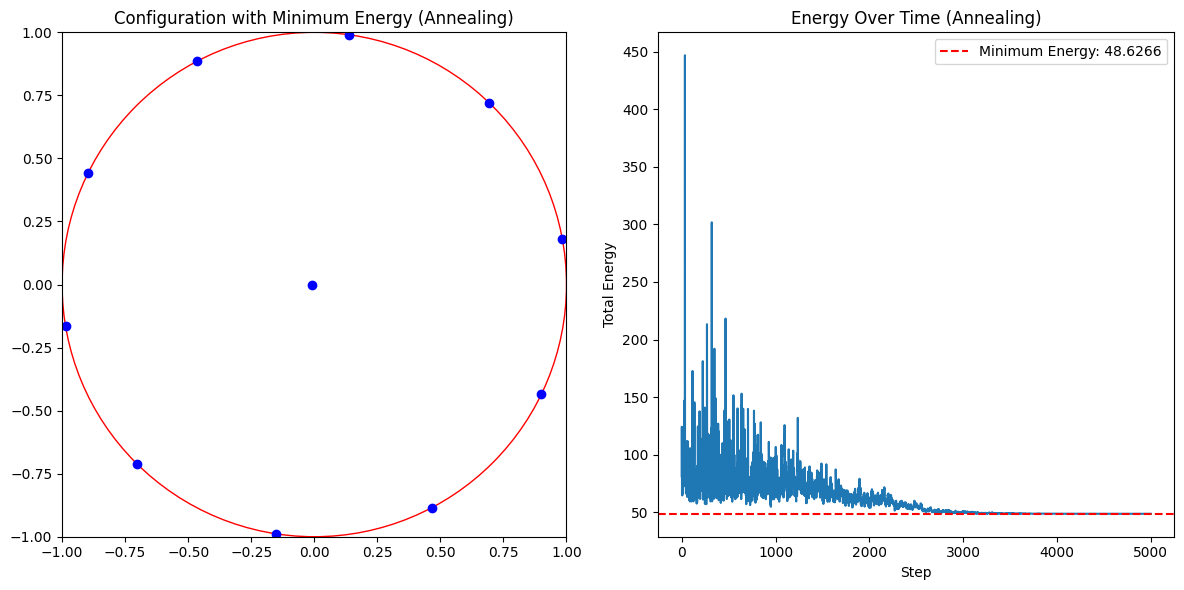

In [242]:

# Parameters
n_particles = 11 # Number of particles
circle_radius = 1
simulation_steps = 5_000
initial_step_size = 0.5
final_step_size = 0.02
initial_temperature = 25 * n_particles
final_temperature = 0.001

# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_charged_particles_individual_steps(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()

0 1.1256341116076296 220
1000 1.0023878150020527 64.29547553378046
2000 1.086204203743207 18.7904917005226
3000 1.2547802079665493 5.491561815448432
4000 1.0182093753153327 1.6049208106700352
5000 0.9976317216657583 0.4690415759822277
6000 1.0005679410434558 0.13707841442223223
7000 0.5083270466906304 0.04006146291224563
8000 0.8724946241896118 0.011708049129644309
9000 1.3938290041804641e-25 0.003421702665287926
0 1.0720509159737581 240
1000 1.0477851909398246 69.53286393005372
2000 1.0474009333445435 20.14507985964735
3000 1.09584631121053 5.836437903087173
4000 1.5326899022064142 1.6909343439648672
5000 0.6921900684605236 0.4898979485565158
6000 0.43717764359599925 0.14193336415246924
7000 1.379850711501896 0.04112097206978498
8000 0.6530434782149759 0.011913578981666256
9000 4.954408071440912e-17 0.003451605276050609
0 0.9949927850979221 260
1000 1.108693751454647 74.72673601984368
2000 1.0258806077241298 21.47725029299757
3000 1.0461770669607375 6.172787742603613
4000 0.0026547607

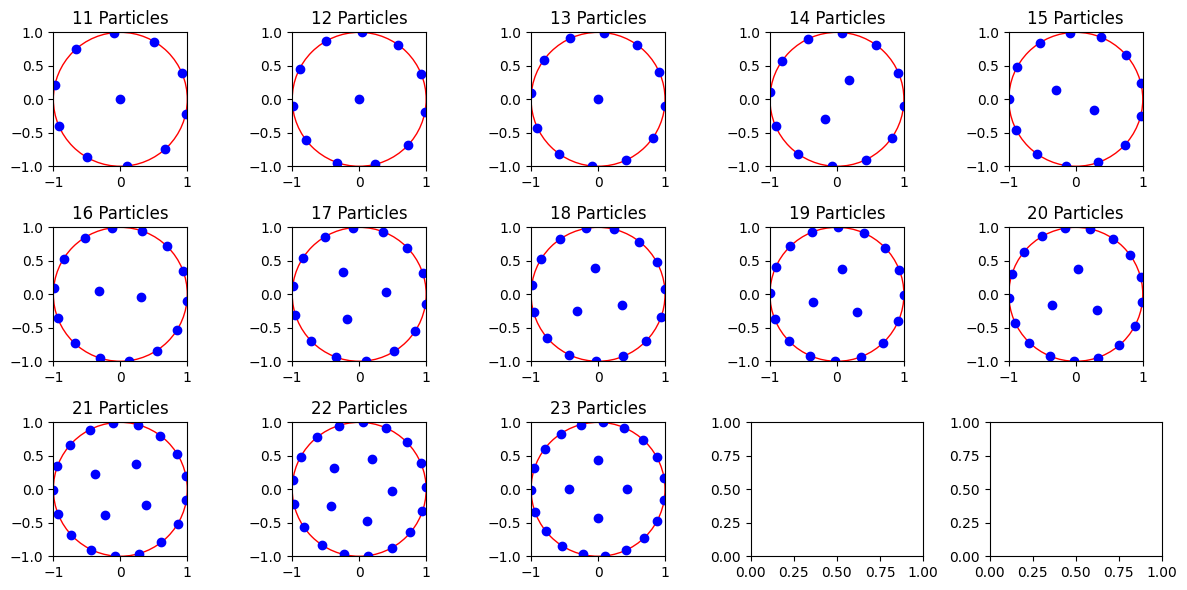

In [220]:

# Parameters
circle_radius = 1
simulation_steps = 10_000
initial_step_size = 0.6
final_step_size = 0.02

final_temperature = 0.001

# Number of rows and columns in the subplot grid
nrows = 3
ncols = 5

# Create a figure with subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))

# Iterate over the specified number of particles
for i, n_particles in enumerate(range(11, 24)):

    initial_temperature = 20 * n_particles
    # Run the simulation for each particle count
    annealing_particles, _, _ = simulate_charged_particles_individual_steps(
        n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
    )

    # Plot the configuration for each particle count
    ax = axes[i // ncols, i % ncols]  # Select the correct subplot
    circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
    ax.add_artist(circle)
    ax.scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
    ax.set_xlim([-circle_radius, circle_radius])
    ax.set_ylim([-circle_radius, circle_radius])
    ax.set_title(f"{n_particles} Particles")
    ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

In [53]:
def exponential_cooling(T0,t,a=0.9):
    return T0*a**t

def linear_cooling(T0,t,e):
    return T0-t*e

def logarithmic_cooling(T0,t,c,d):
    return c/np.log(t+d)


### Exponential cooling

In [54]:
def simulate_exp_annealing(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp):
    """ Simulate the charged particles with simulated annealing, updating all particles at once. """
    particles = initialize_particles_center_bias(n, radius)
    min_energy_config = None
    min_energy = np.inf
    energies = []

    temperature = initial_temp
    step_size = initial_step_size

    # Calculate the cooling and step size rates
    # cooling_rate = (final_temp / initial_temp) ** (1 / steps)
    step_rate = (final_step_size / initial_step_size) ** (1 / steps)

    for step in range(steps):

        forces, current_energy = compute_forces_and_energy_vectorized(particles, radius)

        # Calculate new positions for all particles
        new_particles = update_particle_positions(particles, step_size, radius)
        new_energy = compute_forces_and_energy_vectorized(new_particles, radius)[1]

        # Decide whether to accept the new configuration
        if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
            particles = new_particles
            current_energy = new_energy
        print(step, np.exp((current_energy - new_energy) / temperature), temperature)
        # Update energy, temperature, and step size after each step
        energy = compute_forces_and_energy_vectorized(particles, radius)[1]
        energies.append(energy)

        if energy < min_energy:
            min_energy = energy
            min_energy_config = particles.copy()

       
        temperature = exponential_cooling(initial_temperature,step,0.99)
        step_size *= step_rate

    return min_energy_config, min_energy, energies

In [55]:

# Parameters
n_particles = 11  # Number of particles
circle_radius = 1  # Radius of the circle
simulation_steps = 7500  # Number of steps in the simulation
initial_step_size = 0.3
final_step_size = 0.01
initial_temperature = 250  # Reduced initial temperature
final_temperature = 0.001  # Reduced final temperature


# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_exp_annealing(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()

TypeError: compute_forces_and_energy_vectorized() takes 1 positional argument but 2 were given